In this notebook, I will show how to produce saturation curve using saturation data produced by [PyPan](https://github.com/jsgounot/PyPan) and [CFreec](https://github.com/jsgounot/CFreecW). The saturation curve is made using the [optimize curve available within the scipy package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). While I propose here default arguments, I strongly encourage to look at the documentation for more information about all the arguments. Since the fitting of your curve mostly depend of the law and the option you use, it might requiere a lot of trials before getting something good with your own data. Take your time ! Fitting is not something easy.

In this notebook, I will use the result file produced by the [saturation](https://github.com/jsgounot/PyPan#saturation-curve) function provided within PyPan. Note than you can couple all matrix files, which mean than you can use both results from PyPan and by CFreecW with the [make_matrix](https://github.com/jsgounot/CFreecW#cnv-matrix) function, or even your own made files.

In [2]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
import pylab as plt
import seaborn as sns

### Making the graph

First we load data produced by the [saturation](https://github.com/jsgounot/PyPan#saturation-curve) function.

In [3]:
fname = "/Users/jsgounot/Desktop/TEMP/TEMP1/sat.tsv"
df = pd.read_csv(fname, sep="\t", index_col=0)
df.head()

,core,nsample,pan
0,6694,1,6694
1,6743,1,6743
2,6584,1,6584
3,6632,1,6632
4,6694,1,6694


We then need to define the argument which will be used by the curve fit function. Here are examples of them, but you might change them after.

In [10]:
LAW_CORE = LAW_PAN = lambda x, a, b, c : np.nan_to_num(a * np.power(x, -b) + c)
P0_CORE = P0_PAN = [100, -0.4, 5000]
BOUNDS_CORE = BOUNDS_PAN = [(0, -np.inf, 2000), (2000, np.inf, 7000)]

Next is the function to produce the graph.

In [20]:
COLOR_CORE = sns.color_palette()[0]
COLOR_PAN = sns.color_palette()[1]

def non_linear_reg(fun, col1, col2, data, ax, kwargs_cfit={}, yvalues_plot=None, nid=None, * args, ** kwargs) :
    # https://stackoverflow.com/questions/46497892/non-linear-regression-in-seaborn-python
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    # Non linear regression using scipy
    # You have to provide a function which will take X, A, B and C as arguments

    c1, c2 = np.array(data[col1]), np.array(data[col2])
    popt, pcov = curve_fit(fun, c1, c2, ** kwargs_cfit)
    
    # r2 calculation
    # https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    
    residuals = c2 - fun(c1, * popt)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((c2 - np.mean(c2)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    c1 = yvalues_plot if yvalues_plot is not None else c1
    yvalues = fun(c1, * popt)
    
    if not yvalues.any() : raise Exception("Unable to find yvalues with this law")
    ax.plot(c1, yvalues, * args, ** kwargs)

    res = {estimator : popt[idx] for idx, estimator in enumerate("abc")}
    res["r2"] = r2
    res["nlr_y"] = yvalues

    return res

def make_graph(df, max_dist=0, boxplot=False) :
    fig, ax = plt.subplots(figsize=(18, 9))
    smax = max_dist if max_dist > df["nsample"].max() else df["nsample"].max()
    sres_nlr = []
    
    # Core Genome
    if boxplot :
        sns.boxplot(data=df, x="nsample", y="core", color=COLOR_CORE, ax=ax)
    else :
        sns.lineplot(data=df, x="nsample", y="core", ci="sd", color=COLOR_CORE, ax=ax)

    res_nlr = non_linear_reg(LAW_CORE, "nsample", "core", df, ax, color = COLOR_CORE, 
              kwargs_cfit={"max_nfev" : 20000, "p0" : P0_CORE, "bounds" : BOUNDS_CORE},
              yvalues_plot=[i for i in range(1, smax)], alpha=.7, linestyle="--")

    min_value = min(df["core"].min(), res_nlr["nlr_y"].min())
    subnlr = {key : value for key, value in res_nlr.items() if key != "nlr_y"}
    sres_nlr.append({"kind" : "core", ** subnlr})

    # Pan Genome
    if boxplot :
        sns.boxplot(data=df, x="nsample", y="pan", color=COLOR_PAN, ax=ax)
    else :
        sns.lineplot(data=df, x="nsample", y="pan", ci="sd", color=COLOR_PAN, ax=ax)

    res_nlr = non_linear_reg(LAW_PAN, "nsample", "pan", df, ax, color = COLOR_PAN, 
              kwargs_cfit={"max_nfev" : 20000, "p0" : P0_PAN, "bounds" : BOUNDS_PAN},
              yvalues_plot=[i for i in range(1, smax)], alpha=.7, linestyle="--")

    max_value = max(df["pan"].max(), res_nlr["nlr_y"].max())
    subnlr = {key : value for key, value in res_nlr.items() if key != "nlr_y"}
    sres_nlr.append({"kind" : "pan", ** subnlr})

    ax.set_xlabel("# Samples", size=15)
    ax.set_ylabel("# ORFs", size=15)
    
    print (sres_nlr)

Using this function, you should be able to get a graphical output like this. Since fitting curve is an iterative process, it can take time depending of the number of samples you got or even the shape of your data.

[{'kind': 'core', 'a': 1999.9999999999698, 'b': 0.09384078016569015, 'c': 4707.303786142263, 'r2': 0.8982825104335864}, {'kind': 'pan', 'a': 350.4751853182115, 'b': -0.27299277563002367, 'c': 6351.880143714857, 'r2': 0.9524968204182076}]


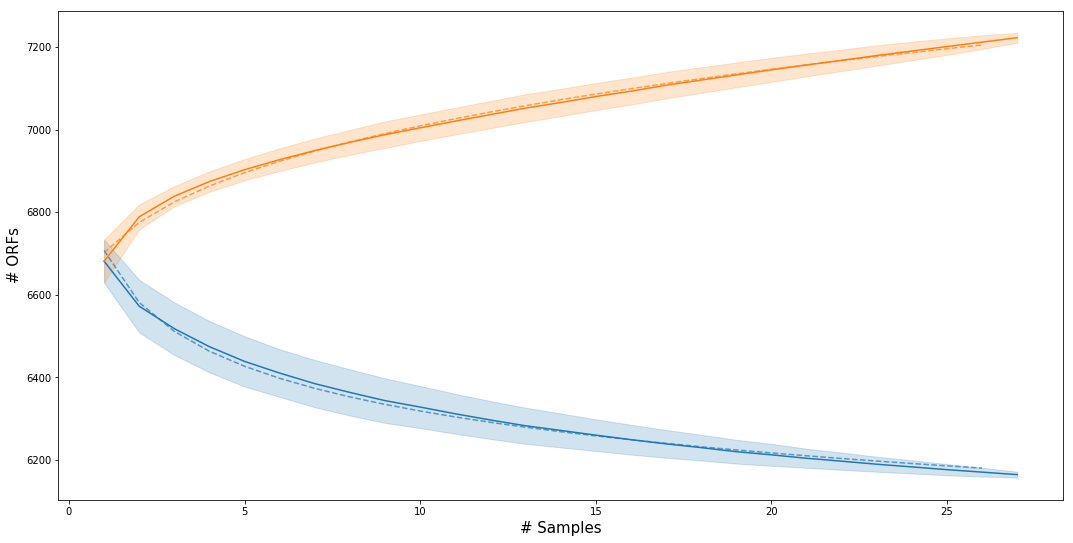

In [23]:
make_graph(df)

Along your graphical result, you also get the resulting values from the curve fit function, including the r2 value for both fitting curve. By default a [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is used, which show a confidence interval of your data, however you can also show a boxplot instead.

[{'kind': 'core', 'a': 1999.9999999999698, 'b': 0.09384078016569015, 'c': 4707.303786142263, 'r2': 0.8982825104335864}, {'kind': 'pan', 'a': 350.4751853182115, 'b': -0.27299277563002367, 'c': 6351.880143714857, 'r2': 0.9524968204182076}]


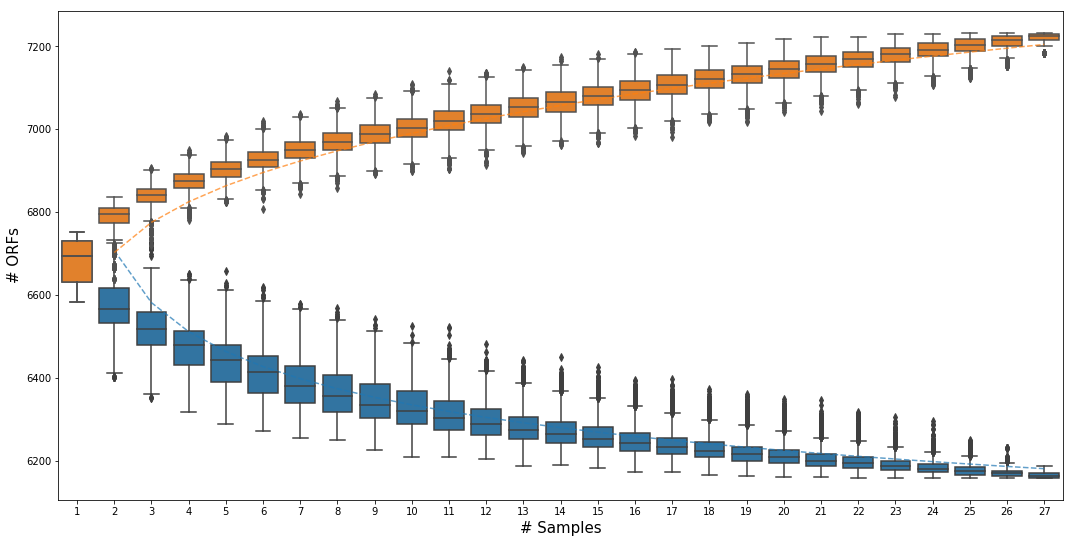

In [24]:
make_graph(df, boxplot=True)

You can also choose to extend the prediction using the `max_dist` argument

[{'kind': 'core', 'a': 1999.9999999999698, 'b': 0.09384078016569015, 'c': 4707.303786142263, 'r2': 0.8982825104335864}, {'kind': 'pan', 'a': 350.4751853182115, 'b': -0.27299277563002367, 'c': 6351.880143714857, 'r2': 0.9524968204182076}]


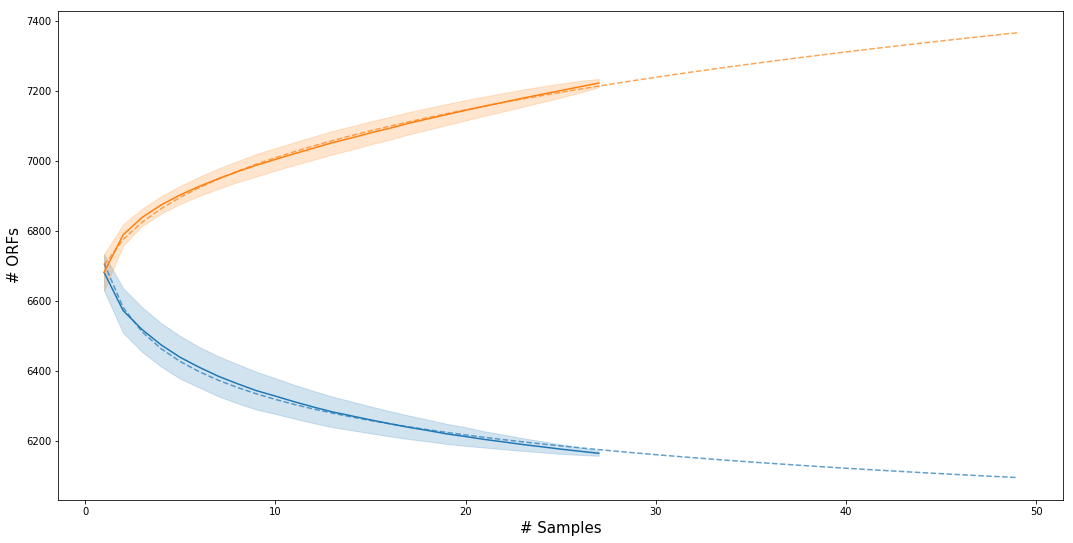

In [25]:
make_graph(df, max_dist=50)

### Quick determination of the plateau

Here is a quick code to determine the "plateau", meaning the number of samples you need until you don't gain or loss a gene when adding a new sample based on your saturation law.

In [34]:
def look_stable(law, popt, kind, maxiter=1000000, verbose=False) :
    # used by search table

    i = 0
    previous = law(1, ** popt) 
    
    while True :
        i += 1
        if i > maxiter :
            return None

        nextone = law(i + 1, ** popt)
        if verbose : print (kind, i, nextone, previous)

        if kind == "pan" and nextone - previous < 1 :
            return i

        elif kind == "core" and previous - nextone < 1 :
            return i  
        
        previous = nextone

To run this function, you need results provided before

In [35]:
popt = {'a': 1999.9999999999698, 'b': 0.09384078016569015, 'c': 4707.303786142263}
print (look_stable(LAW_CORE, popt, "core"))

120


In [36]:
popt = {'a': 350.4751853182115, 'b': -0.27299277563002367, 'c': 6351.880143714857}
print (look_stable(LAW_CORE, popt, "pan"))

530


Using these results, you can say that you need 120 samples and 530 samples until getting saturation of your genome for the core and the pangenomes respectively. These functions provide an easy way to produce saturation curve, however multiple laws and methods exist and might be more suited to your need. Good luck !!